<시작하세요! 텐서플로 2.0 프로그래밍> 예제코드입니다.

- 예제 코드를 실행하기 위해서는 [파일] > [드라이브에 사본 저장]으로 본인의 계정에 사본을 만든 다음 실행하면 됩니다.
- 예제 코드는 [깃허브 저장소](https://github.com/wikibook/tf2)에서도 동일하게 제공됩니다. 예제에 대한 질문이나 책에 대한 질문은 깃허브 저장소의 [Issues](https://github.com/wikibook/tf2/issues)에 올려주세요.
- 각 장의 예제 파일은 처음부터 끝까지 실행하는 상황을 가정하고 작성되었습니다. 혹시 세션이 다운되는 등의 이유로 실행이 되지 않는 경우가 있다면, 필요한 라이브러리를 import 하신 후에 실행하시면 됩니다. (tensorflow, numpy, pandas 등)

In [1]:
# 텐서플로 2 버전 선택
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf
import numpy as np

In [18]:
# 텐서플로우 버전 확인
print(tf.__version__)

2.12.0


# 7.2 주요 레이어 정리

## 7.2.1 SimpleRNN 레이어

In [2]:
# 7.1 SimpleRNN 레이어 생성 코드, units = 1은 뉴론의 갯수, 
# 활성화 함수 tanh는 -1 ~ 1 값을 리턴 
rnn1 = tf.keras.layers.SimpleRNN(units=1, activation='tanh', return_sequences=True)

In [3]:
# 7.2 시퀀스 예측 데이터 생성
# 입력 [0.0, 0.1, 0.2, 0.3] -> 출력 [0.4]를 예측하는 네트워크 
X = []
Y = []
for i in range(6):
    # [0,1,2,3], [1,2,3,4] 같은 정수의 시퀀스를 만듭니다.
    lst = list(range(i,i+4))

    # 위에서 구한 시퀀스의 숫자들을 각각 10으로 나눈 다음 저장합니다.
    # SimpleRNN 에 각 타임스텝에 하나씩 숫자가 들어가기 때문에 여기서도 하나씩 분리해서 배열에 저장합니다.
    # 람다식: def fcn(x,y): return x + y => (lambda x,y: x + y)(10,20)으로 사용 
    # map(함수, 리스트)
    X.append(list(map(lambda c: [c/10], lst)))

    # 정답에 해당하는 4, 5 등의 정수를 역시 위처럼 10으로 나눠서 저장합니다.
    Y.append((i+4)/10)
    
X = np.array(X)
Y = np.array(Y)
for i in range(len(X)):
    print(X[i], Y[i])

[[0. ]
 [0.1]
 [0.2]
 [0.3]] 0.4
[[0.1]
 [0.2]
 [0.3]
 [0.4]] 0.5
[[0.2]
 [0.3]
 [0.4]
 [0.5]] 0.6
[[0.3]
 [0.4]
 [0.5]
 [0.6]] 0.7
[[0.4]
 [0.5]
 [0.6]
 [0.7]] 0.8
[[0.5]
 [0.6]
 [0.7]
 [0.8]] 0.9


In [4]:
# 7.3 시퀀스 예측 모델 정의
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(units=10, return_sequences=False, input_shape=[4,1]),# (timesteps, input_dim) input-dim은 입력 벡터의 크기
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 10)                120       
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________


In [5]:
# 7.4 네트워크 훈련 및 결과 확인
model.fit(X, Y, epochs=100, verbose=0)#X는 [6,4,1] 6은 배치, 4는 timesteps, 1은 input_dim이다 > 그림 7.5 sequence 예측 모델의 구조 
print(np.shape(X)) # shape(batch size, timesteps, dimension),
# dimension은 column 숫자, 
# timesteps는 시간에 따라 입력되는 값: h,e,l,l,o >
#  h는 x0[1,0,0,0], e는 x1[0,1,0,0] > dim은 4가 된다
# batch는 hello, elloh, helhel 등이 배치이다. 
print(model.predict(X))

(6, 4, 1)
1/1 [==============================] - 0s 114ms/step
[[0.44717646]
 [0.5527404 ]
 [0.6430595 ]
 [0.7173253 ]
 [0.776369  ]
 [0.8217969 ]]


In [6]:
# 7.5 학습되지 않은 시퀀스에 대한 예측 결과
# simple RNN의 학습 결과 
print(model.predict(np.array([[[0.6],[0.7],[0.8],[0.9]]])))
print(model.predict(np.array([[[-0.1],[0.0],[0.1],[0.2]]])))

1/1 [==============================] - 0s 15ms/step
[[0.8553952]]
1/1 [==============================] - 0s 14ms/step
[[0.32963464]]


## 7.2.2 LSTM 레이어

In [7]:
# 7.6 곱셈 문제 데이터 생성
X = []
Y = []
for i in range(3000):
    # 0~1 사이의 랜덤한 숫자 100 개를 만듭니다.
    lst = np.random.rand(100)
    # 마킹할 숫자 2개의 인덱스를 뽑습니다.
    idx = np.random.choice(100, 2, replace=False)
    # 마킹 인덱스가 저장된 원-핫 인코딩 벡터를 만듭니다.
    zeros = np.zeros(100)
    zeros[idx] = 1
    # 마킹 인덱스와 랜덤한 숫자를 합쳐서 X 에 저장합니다.
    X.append(np.array(list(zip(zeros, lst)))) # 첫째 열은 마킹 인덱스
    # 마킹 인덱스가 1인 값들만 서로 곱해서 Y 에 저장합니다.
    Y.append(np.prod(lst[idx]))
    
print(X[0], Y[0]) # 3000개 중에서 첫번째 값 

[[0.         0.11866052]
 [0.         0.42755287]
 [0.         0.42470602]
 [0.         0.36379681]
 [0.         0.88757293]
 [0.         0.08890125]
 [0.         0.1591324 ]
 [0.         0.50077712]
 [0.         0.07646451]
 [0.         0.14264327]
 [0.         0.98484219]
 [0.         0.99241302]
 [0.         0.33235718]
 [0.         0.10088076]
 [0.         0.68718324]
 [0.         0.22016595]
 [0.         0.29596311]
 [0.         0.62910296]
 [0.         0.13900217]
 [0.         0.46479923]
 [0.         0.02222978]
 [0.         0.89039543]
 [0.         0.26370117]
 [0.         0.92900591]
 [1.         0.86975656]
 [0.         0.12347357]
 [0.         0.91808563]
 [0.         0.31333323]
 [0.         0.71815858]
 [0.         0.12198855]
 [0.         0.42974575]
 [0.         0.91341398]
 [0.         0.48804767]
 [0.         0.17520523]
 [0.         0.08110279]
 [0.         0.64622498]
 [0.         0.05846737]
 [0.         0.57939716]
 [0.         0.37946205]
 [0.         0.6854091 ]


In [8]:
# 7.7 SimpleRNN 레이어를 사용한 곱셈 문제 모델 정의
model = tf.keras.Sequential([ # 그림 7.10 > units = 30의 의미는 각 cell의 hidden units > 100개의 time steps에 대하여 30개의 units이므로 (none, 100, 30)
    tf.keras.layers.SimpleRNN(units=30, return_sequences=True, input_shape=[100,2]),# return_sequences = true는 레이어의 출력을 다음 레이어에 전달 
    tf.keras.layers.SimpleRNN(units=30),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 100, 30)           990       
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 30)                1830      
                                                                 
 dense_1 (Dense)             (None, 1)                 31        
                                                                 
Total params: 2,851
Trainable params: 2,851
Non-trainable params: 0
_________________________________________________________________


In [9]:
# 7.8 SimpleRNN 네트워크 학습 - 학습 시간 소요됨 
X = np.array(X)
Y = np.array(Y)
# 2560개의 데이터만 학습시킵니다. validation 데이터는 20% 로 지정합니다.
history = model.fit(X[:2560], Y[:2560], epochs=100, validation_split=0.2)

Epoch 1/100
64/64 [==============================] - 2s 16ms/step - loss: 0.1466 - val_loss: 0.0484
Epoch 2/100
64/64 [==============================] - 1s 13ms/step - loss: 0.0520 - val_loss: 0.0479
Epoch 3/100
64/64 [==============================] - 1s 13ms/step - loss: 0.0511 - val_loss: 0.0481
Epoch 4/100
64/64 [==============================] - 1s 13ms/step - loss: 0.0505 - val_loss: 0.0481
Epoch 5/100
64/64 [==============================] - 1s 13ms/step - loss: 0.0507 - val_loss: 0.0501
Epoch 6/100
64/64 [==============================] - 1s 13ms/step - loss: 0.0505 - val_loss: 0.0486
Epoch 7/100
64/64 [==============================] - 1s 13ms/step - loss: 0.0499 - val_loss: 0.0482
Epoch 8/100
64/64 [==============================] - 1s 13ms/step - loss: 0.0500 - val_loss: 0.0483
Epoch 9/100
64/64 [==============================] - 1s 13ms/step - loss: 0.0509 - val_loss: 0.0483
Epoch 10/100
64/64 [==============================] - 1s 13ms/step - loss: 0.0522 - val_loss: 0.0495

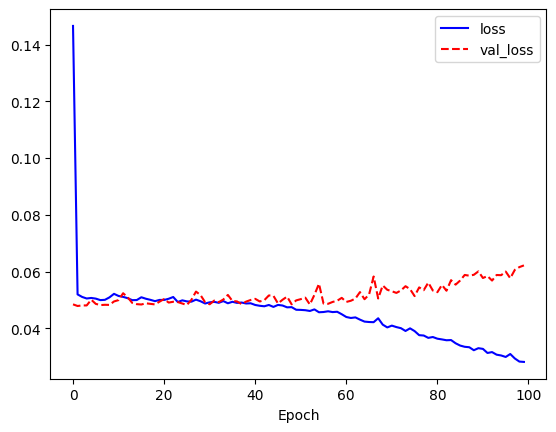

In [10]:
# 7.9 SimpleRNN 네트워크 학습 결과 확인
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()
# 훈련데이터 손실은 감소하나 검증 데이터는 손실이 증가함 - 전형적인 과적합 그래프 

In [11]:
# 7.10 Test 데이터에 대한 예측 정확도 확인
model.evaluate(X[2560:], Y[2560:])
#  evaluate 메서드를 사용하여 검증 데이터의 loss 값을 계산하고 loss에 저장합니다.
# predict 메서드를 사용하여 검증 데이터의 예측값을 계산하고 predictions에 저장합니다.
prediction = model.predict(X[2560:2560+5])
# 5개 테스트 데이터에 대한 예측을 표시합니다.
for i in range(5):
    print(Y[2560+i], '\t', prediction[i][0], '\tdiff:', abs(prediction[i][0] - Y[2560+i]))
    
prediction = model.predict(X[2560:])
fail = 0
for i in range(len(prediction)):
    # 오차가 0.04 이상이면 오답입니다.
    if abs(prediction[i][0] - Y[2560+i]) > 0.04:
        fail += 1
print('correctness:', (440 - fail) / 440 * 100, '%')

1/1 [==============================] - 0s 158ms/step
0.13823351145760146 	 0.34103343 	diff: 0.20279991744979295
0.18720359795185637 	 0.21030223 	diff: 0.023098635744127516
0.8859112227038731 	 0.44941172 	diff: 0.4364995026664128
0.04963454180132261 	 0.2752327 	diff: 0.225598160692345
0.8923374678301343 	 0.46385118 	diff: 0.42848628417725654
14/14 [==============================] - 0s 4ms/step
correctness: 10.454545454545453 %


In [12]:
# 7.11 LSTM 레이어를 사용한 곱셈 문제 모델 정의
# simple rnn을 LSTM으로 변경한 것 이외는 동일 
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(units=30, return_sequences=True, input_shape=[100,2]),
    tf.keras.layers.LSTM(units=30),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 30)           3960      
                                                                 
 lstm_1 (LSTM)               (None, 30)                7320      
                                                                 
 dense_2 (Dense)             (None, 1)                 31        
                                                                 
Total params: 11,311
Trainable params: 11,311
Non-trainable params: 0
_________________________________________________________________


In [13]:
# 7.12 LSTM 네트워크 학습
X = np.array(X)
Y = np.array(Y)
history = model.fit(X[:2560], Y[:2560], epochs=100, validation_split=0.2)

Epoch 1/100
64/64 [==============================] - 4s 30ms/step - loss: 0.0536 - val_loss: 0.0478
Epoch 2/100
64/64 [==============================] - 1s 22ms/step - loss: 0.0504 - val_loss: 0.0474
Epoch 3/100
64/64 [==============================] - 1s 23ms/step - loss: 0.0505 - val_loss: 0.0481
Epoch 4/100
64/64 [==============================] - 1s 22ms/step - loss: 0.0504 - val_loss: 0.0488
Epoch 5/100
64/64 [==============================] - 1s 23ms/step - loss: 0.0502 - val_loss: 0.0477
Epoch 6/100
64/64 [==============================] - 1s 23ms/step - loss: 0.0501 - val_loss: 0.0473
Epoch 7/100
64/64 [==============================] - 1s 23ms/step - loss: 0.0503 - val_loss: 0.0474
Epoch 8/100
64/64 [==============================] - 1s 23ms/step - loss: 0.0499 - val_loss: 0.0481
Epoch 9/100
64/64 [==============================] - 1s 23ms/step - loss: 0.0506 - val_loss: 0.0475
Epoch 10/100
64/64 [==============================] - 1s 23ms/step - loss: 0.0499 - val_loss: 0.0474

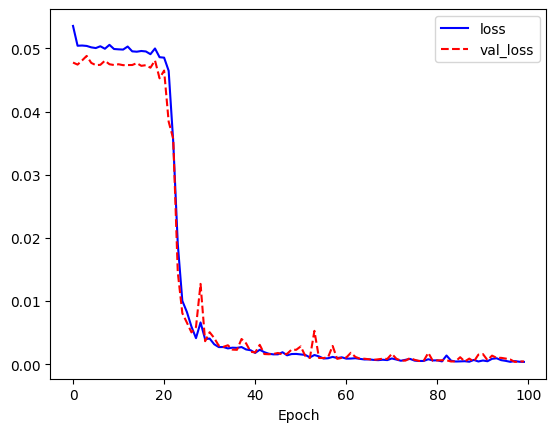

In [14]:
# 7.13 LSTM 네트워크 학습 결과 확인
# 검증 데이터의 학습 결과가 엄청 좋아짐 
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [15]:
# 7.14 Test 데이터에 대한 예측 정확도 확인
model.evaluate(X[2560:], Y[2560:])
prediction = model.predict(X[2560:2560+5]) # 손실은 거의 0에 가깝다 
for i in range(5):
    print(Y[2560+i], '\t', prediction[i][0], '\tdiff:', abs(prediction[i][0] - Y[2560+i]))
    
prediction = model.predict(X[2560:])
cnt = 0
for i in range(len(prediction)):
    if abs(prediction[i][0] - Y[2560+i]) > 0.04:
        cnt += 1
print('correctness:', (440 - cnt) / 440 * 100, '%') # 정확도가 97%

1/1 [==============================] - 0s 494ms/step
0.13823351145760146 	 0.10426111 	diff: 0.03397240371481505
0.18720359795185637 	 0.18044151 	diff: 0.006762084294286486
0.8859112227038731 	 0.871467 	diff: 0.014444228418289629
0.04963454180132261 	 0.048508517 	diff: 0.0011260243571888512
0.8923374678301343 	 0.9004273 	diff: 0.00808981402640252
14/14 [==============================] - 0s 8ms/step
correctness: 93.86363636363636 %


## 7.2.3 GRU 레이어

In [16]:
# 7.15 GRU 레이어를 사용한 곱셈 문제 모델 정의
model = tf.keras.Sequential([
    tf.keras.layers.GRU(units=30, return_sequences=True, input_shape=[100,2]),
    tf.keras.layers.GRU(units=30),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary() # LSTM 보다 Param#이 현저히 줄어들다 

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 100, 30)           3060      
                                                                 
 gru_1 (GRU)                 (None, 30)                5580      
                                                                 
 dense_3 (Dense)             (None, 1)                 31        
                                                                 
Total params: 8,671
Trainable params: 8,671
Non-trainable params: 0
_________________________________________________________________


In [19]:
# 7.16 GRU 네트워크 학습 - 학습 시간이 단축됨됨
X = np.array(X)
Y = np.array(Y)
history = model.fit(X[:2560], Y[:2560], epochs=100, validation_split=0.2)

Epoch 1/100
64/64 [==============================] - 1s 22ms/step - loss: 3.1709e-04 - val_loss: 4.5945e-04
Epoch 2/100
64/64 [==============================] - 1s 22ms/step - loss: 2.8286e-04 - val_loss: 3.5324e-04
Epoch 3/100
64/64 [==============================] - 1s 22ms/step - loss: 2.5639e-04 - val_loss: 3.1303e-04
Epoch 4/100
64/64 [==============================] - 1s 22ms/step - loss: 2.6339e-04 - val_loss: 3.0552e-04
Epoch 5/100
64/64 [==============================] - 1s 22ms/step - loss: 2.3181e-04 - val_loss: 3.2438e-04
Epoch 6/100
64/64 [==============================] - 1s 22ms/step - loss: 2.5192e-04 - val_loss: 3.9751e-04
Epoch 7/100
64/64 [==============================] - 1s 22ms/step - loss: 3.0491e-04 - val_loss: 3.6489e-04
Epoch 8/100
64/64 [==============================] - 1s 22ms/step - loss: 2.9971e-04 - val_loss: 3.4242e-04
Epoch 9/100
64/64 [==============================] - 1s 22ms/step - loss: 3.6955e-04 - val_loss: 3.6901e-04
Epoch 10/100
64/64 [========

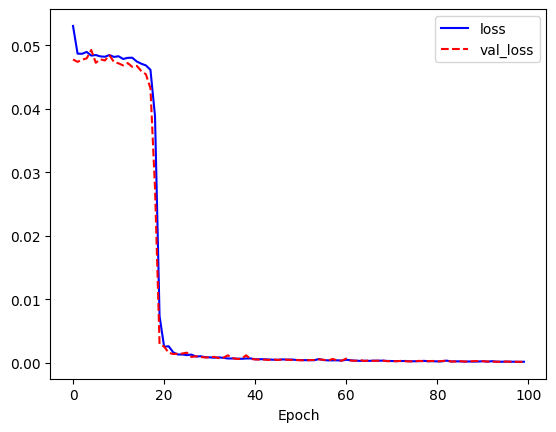

In [ ]:
# 7.17 GRU 네트워크 학습 결과 확인
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
# 7.18 Test 데이터에 대한 예측 정확도 확인
model.evaluate(X[2560:], Y[2560:])
prediction = model.predict(X[2560:2560+5])
for i in range(5):
    print(Y[2560+i], '\t', prediction[i][0], '\tdiff:', abs(prediction[i][0] - Y[2560+i]))
    
prediction = model.predict(X[2560:])
cnt = 0
for i in range(len(prediction)):
    if abs(prediction[i][0] - Y[2560+i]) > 0.04:
        cnt += 1
print('correctness:', (440 - cnt) / 440 * 100, '%')

1/1 [==============================] - 1s 649ms/step
0.564851160115554 	 0.5613057 	diff: 0.0035454583829185315
0.29603959615402436 	 0.28991088 	diff: 0.006128713442613842
0.3232612294251243 	 0.3125314 	diff: 0.010729817777327677
0.014846627591851985 	 0.027473897 	diff: 0.01262726915001508
0.006496615919556574 	 0.0040568225 	diff: 0.002439793410983042
14/14 [==============================] - 0s 6ms/step
correctness: 99.31818181818181 %


# 7.3 긍정, 부정 감성 분석

In [24]:
# 7.19 Naver Sentiment Movie Corpus v1.0 다운로드
path_to_train_file = tf.keras.utils.get_file('train.txt', 'https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt')
path_to_test_file = tf.keras.utils.get_file('test.txt', 'https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt')

4893335/4893335 [==============================] - 1s 0us/step


In [25]:
# 7.20 데이터 로드 및 확인
# 데이터를 메모리에 불러옵니다. encoding 형식으로 utf-8 을 지정해야합니다.
train_text = open(path_to_train_file, 'rb').read().decode(encoding='utf-8')
test_text = open(path_to_test_file, 'rb').read().decode(encoding='utf-8')

# 텍스트가 총 몇 자인지 확인합니다.
print('Length of text: {} characters'.format(len(train_text)))
print('Length of text: {} characters'.format(len(test_text)))
print()

# 처음 300 자를 확인해봅니다.
print(train_text[:300])
print(test_text[:300])

Length of text: 6937271 characters
Length of text: 2318260 characters

id	document	label
9976970	아 더빙.. 진짜 짜증나네요 목소리	0
3819312	흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나	1
10265843	너무재밓었다그래서보는것을추천한다	0
9045019	교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정	0
6483659	사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다	1
5403919	막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.	0
7797314	원작의
id	document	label
6270596	굳 ㅋ	1
9274899	GDNTOPCLASSINTHECLUB	0
8544678	뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아	0
6825595	지루하지는 않은데 완전 막장임... 돈주고 보기에는....	0
6723715	3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??	0
7898805	음악이 주가 된, 최고의 음악영화	1
6315043	진정한 쓰레기	0
6097171	마치 미국애니에서 튀어나온듯한 창의력없는 로봇디자인부터


In [26]:
# 7.21 학습을 위한 정답 데이터(Y) 만들기
#train_text를 \n으로 분리한 결과에서 [1:]은 헤더 ("id document label")를 제외한 행에 대하여
# 각 row에 대하여 \t로 분리한 후에 인덱스를 0부터 세기 때문에 [2]세번째 분리된 값: label 값이 분리된다 
train_Y = np.array([[int(row.split('\t')[2])] for row in train_text.split('\n')[1:] if row.count('\t') > 0])
test_Y = np.array([[int(row.split('\t')[2])] for row in test_text.split('\n')[1:] if row.count('\t') > 0])
print(train_Y.shape, test_Y.shape)
print(train_Y[:5])

(150000, 1) (50000, 1)
[[0]
 [1]
 [0]
 [0]
 [1]]


In [27]:
# 7.22 train 데이터의 입력(X)에 대한 정제(Cleaning) > 불필요한 기호 등을 제거거
# 자연어를 토큰화(tokenization)
import re # 정규표현식 regular expression library
# From https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
def clean_str(string):    
    # ^ 기호는 한글 영문 숫자 등이 아닌 것을 말함
    # r은 raw 문자를 나타냄 - 특수문자 처리 안해도 된다 
    # sub => substitue
    string = re.sub(r"[^가-힣A-Za-z0-9(),!?\'\`]", " ", string) #string에 대하여 첫째 인수에 대한 것을 두번째 인수로 교체체
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    string = re.sub(r"\'{2,}", "\'", string)
    string = re.sub(r"\'", "", string)

    return string.lower()

# 헤더를 제외한 행에 대하여 두번째 열을 뽑아낸다 
train_text_X = [row.split('\t')[1] for row in train_text.split('\n')[1:] if row.count('\t') > 0]
train_text_X = [clean_str(sentence) for sentence in train_text_X]
# 문장을 띄어쓰기 단위로 단어 분리
sentences = [sentence.split(' ') for sentence in train_text_X]
for i in range(5):
    print(sentences[i])

['아', '더빙', '진짜', '짜증나네요', '목소리']
['흠', '포스터보고', '초딩영화줄', '오버연기조차', '가볍지', '않구나']
['너무재밓었다그래서보는것을추천한다']
['교도소', '이야기구먼', '솔직히', '재미는', '없다', '평점', '조정']
['사이몬페그의', '익살스런', '연기가', '돋보였던', '영화', '!', '스파이더맨에서', '늙어보이기만', '했던', '커스틴', '던스트가', '너무나도', '이뻐보였다']


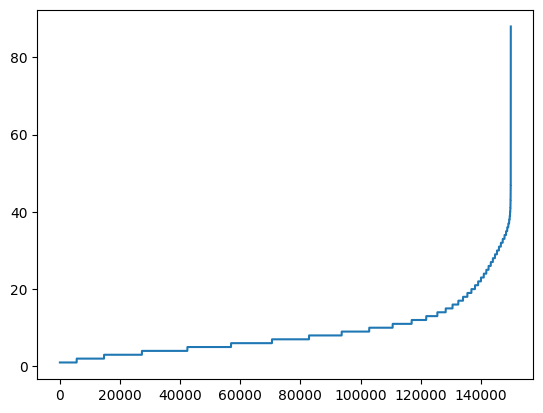

142587


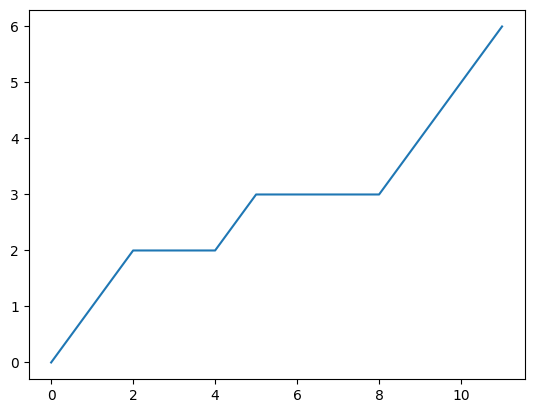

In [28]:
# 7.23 각 문장의 단어 길이 확인
import matplotlib.pyplot as plt
sentence_len = [len(sentence) for sentence in sentences]
sentence_len.sort()
#print(sentence_len)
#sentences -> 댓글
plt.plot(sentence_len) #y 축으로 문장의 단어 수수
plt.show()

print(sum([int(l<=25) for l in sentence_len])) # 142,587이 출력됨됨
plt.plot([0,1,2,2,2,3,3,3,3,4,5,6]) #y 축으로 문장의 단어 수수
plt.show()
# y축은 문장의 단어 수, x축은 문장 수 > 대부분의 문장이 40단어 이하이다 
# 25단어 이하인 문장 숫자가 142,587개로 전체 95%이다 >  패딩 길이를 25로 맞춘다 

In [ ]:
# 7.24 단어 정제 및 각 단어의 최대 길이를 조정
sentences_new = []
for sentence in sentences:
    sentences_new.append([word[:5] for word in sentence][:25]) #단어의 최대 길이: 5, 각 문장은 25단어까지 
sentences = sentences_new
for i in range(5):
    print(sentences[i])

['아', '더빙', '진짜', '짜증나네요', '목소리']
['흠', '포스터보고', '초딩영화줄', '오버연기조', '가볍지', '않구나']
['너무재밓었']
['교도소', '이야기구먼', '솔직히', '재미는', '없다', '평점', '조정']
['사이몬페그', '익살스런', '연기가', '돋보였던', '영화', '!', '스파이더맨', '늙어보이기', '했던', '커스틴', '던스트가', '너무나도', '이뻐보였다']


In [ ]:
# 7.25 Tokenizer와 pad_sequences를 사용한 문장 전처리
# 같은 문장 길이(25단어)로 바꾸기 위한 패딩
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=20000) # 출현 빈도가 많은 2만개 단어에 대한 numbering
tokenizer.fit_on_texts(sentences) # tokenizer에 실제 데이터 sentences를 입력
train_X = tokenizer.texts_to_sequences(sentences) # 실제 문장을 입력받아 숫자로 return
train_X = pad_sequences(train_X, padding='post') # 리턴된 숫자에 패딩, post는 뒷 부분에 0을 패딩딩
# 3 행이 0이 된 이유는 잘 사용되지 않는 단어이므로/ 빈도수가 적다 
print(train_X[:5])

[[   25   884     8  5795  1111     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0]
 [  588  5796  6697     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0]
 [   71   346    31    35 10468     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0]
 [  106  5338     4     2  2169   869   573     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0]]


In [ ]:
# 7.26 Tokenizer의 동작 확인 - texts_to_sequences()이 하는 일을 실행으로 확인 
print(tokenizer.index_word[106])
print(tokenizer.index_word[19999])
print(tokenizer.index_word[20000])
temp = tokenizer.texts_to_sequences(['#$#$#', '경우는', '잊혀질', '연기가'])
print(temp)
temp = pad_sequences(temp, padding='post') # 공백은 0으로 변환 
print(temp)

연기가
경우는
잊혀질
[[], [19999], [], [106]]
[[    0]
 [19999]
 [    0]
 [  106]]


In [ ]:
# 7.27 감성 분석을 위한 모델 정의
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(20000, 300, input_length=25),#25개의 단어를 길이 300개의 임베딩 벡터로 변환 
    tf.keras.layers.LSTM(units=50),
    tf.keras.layers.Dense(2, activation='softmax')
])
#여러개의 정답 중 하나는 맞추는 분류 문제 > sparse_categorical-crossentropy
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 25, 300)           6000000   
                                                                 
 lstm_1 (LSTM)               (None, 50)                70200     
                                                                 
 dense_1 (Dense)             (None, 2)                 102       
                                                                 
Total params: 6,070,302
Trainable params: 6,070,302
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 7.28 감성 분석 모델 학습
history = model.fit(train_X, train_Y, epochs=5, batch_size=128, validation_split=0.2)

Epoch 1/5
938/938 [==============================] - 52s 47ms/step - loss: 0.4338 - accuracy: 0.7846 - val_loss: 0.3800 - val_accuracy: 0.8238
Epoch 2/5
938/938 [==============================] - 11s 12ms/step - loss: 0.3252 - accuracy: 0.8481 - val_loss: 0.3883 - val_accuracy: 0.8207
Epoch 3/5
938/938 [==============================] - 10s 11ms/step - loss: 0.2724 - accuracy: 0.8687 - val_loss: 0.4150 - val_accuracy: 0.8198
Epoch 4/5
938/938 [==============================] - 9s 10ms/step - loss: 0.2316 - accuracy: 0.8856 - val_loss: 0.4981 - val_accuracy: 0.8145
Epoch 5/5
938/938 [==============================] - 8s 9ms/step - loss: 0.1952 - accuracy: 0.9029 - val_loss: 0.5907 - val_accuracy: 0.8078


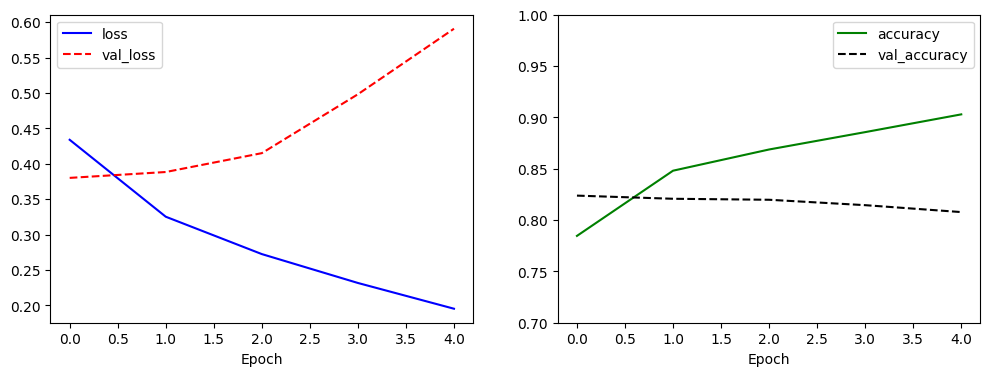

In [ ]:
# 7.29 감성 분석 모델 학습 결과 확인
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'], 'k--', label='val_accuracy')
plt.xlabel('Epoch')
plt.ylim(0.7, 1)
plt.legend()

plt.show() # 네트워크가 과적합 이유는 임베딩 레이어가 random 값부터 시작해서 학습 > 벡터 품질이 좋지 않기 때문이다 
# 개선 방법: 임베딩 레이어를 별도로 학습시킨다. RNN이 아닌 CNN를 사용한다 ???

In [ ]:
# 7.30 테스트 데이터 평가
test_text_X = [row.split('\t')[1] for row in test_text.split('\n')[1:] if row.count('\t') > 0]
test_text_X = [clean_str(sentence) for sentence in test_text_X]
sentences = [sentence.split(' ') for sentence in test_text_X]
sentences_new = []
for sentence in sentences:
    sentences_new.append([word[:5] for word in sentence][:25])
sentences = sentences_new

test_X = tokenizer.texts_to_sequences(sentences)
test_X = pad_sequences(test_X, padding='post')
print(test_X[:5])
model.evaluate(test_X, test_Y, verbose=0) # 테스트 데이터의 정확도 80%

[[  594     1     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0]
 [  357     9  4626   990    69  3348  2773     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0]
 [ 2110    32 12562   506  1450     1     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0]
 [17856   109 12074   244 18890    11  3365   348   468 12715     5     5
      1     0     0     0     0     0     0     0     0     0     0     0
      0]]


[0.5988526344299316, 0.801639974117279]

In [ ]:
# 7.31 임의의 문장 감성 분석 결과 확인
test_sentence = '재미있을 줄 알았는데 완전 실망했다. 너무 졸리고 돈이 아까웠다.'
test_sentence = test_sentence.split(' ')
test_sentences = []
now_sentence = []
for word in test_sentence: # 처음에는 1개 단어, 두번째는 2개 단어, 3번째는 3개 단어 연속 등으로 만듬
    now_sentence.append(word)
    test_sentences.append(now_sentence[:])
    
test_X_1 = tokenizer.texts_to_sequences(test_sentences)
test_X_1 = pad_sequences(test_X_1, padding='post', maxlen=25)
print(test_X_1[:5])
prediction = model.predict(test_X_1)
for idx, sentence in enumerate(test_sentences): # 각 원소를 sentence라 하고 이를 숫자화한 것이 idx
    print(sentence)
    print(prediction[idx])
    # 처음에는 긍정 분석, 나중에는 부정 분석석

[[4696    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]
 [4696  194    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]
 [4696  194  523    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]
 [4696  194  523   32    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]
 [4696  194  523   32    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]]
1/1 [==============================] - 0s 38ms/step
['재미있을']
[0.15659177 0.8434082 ]
['재미있을', '줄']
[0.23043732 0.76956266]
['재미있을', '줄', '알았는데']
[0.4085158 0.5914841]
['재미있을', '줄', '알았는데', '완전']
[0.38852334 0.61147666]
['재미있을', '줄', '알았는데', '완전', '실망했다.']
[0.38852334 0.61147666]
['재미있을', '줄', '알았는데', '완전', '실망했다.', '너무']
[0.39897475 0.6010252 ]
['

# 7.4 자연어 생성

## 7.4.1 단어 단위 생성

In [ ]:
# Andrej Karpathy에 대한 구글링 해볼 필요 - The Unreasonable Effectiveness of RNN
# 셰익스피어 희곡, 소스코드, Latex 문자 단위의 순환 신경망 생성 - 비슷한 구조를 가진 문서 생성 > RNN이 효과적 
# 7.32 조선왕조실록 데이터 파일 다운로드
path_to_file = tf.keras.utils.get_file('input.txt', 'http://bit.ly/2Mc3SOV')

62012502/62012502 [==============================] - 0s 0us/step


In [ ]:
# 7.33 데이터 로드 및 확인
# 데이터를 메모리에 불러옵니다. encoding 형식으로 utf-8 을 지정해야합니다.
train_text = open(path_to_file, 'rb').read().decode(encoding='utf-8') # 데이터 파일 62MB

# 텍스트가 총 몇 자인지 확인합니다.
print('Length of text: {} characters'.format(len(train_text)))
print()

# 처음 100 자를 확인해봅니다.
print(train_text[:500])

Length of text: 26265493 characters

﻿태조 이성계 선대의 가계. 목조 이안사가 전주에서 삼척·의주를 거쳐 알동에 정착하다 
태조 강헌 지인 계운 성문 신무 대왕(太祖康獻至仁啓運聖文神武大王)의 성은 이씨(李氏)요, 휘(諱)는 단(旦)이요, 자(字)는 군진(君晉)이다. 그전의 휘(諱)는 이성계(李成桂)요, 호(號)는 송헌(松軒)이다. 전주(全州)의 대성(大姓)이다. 사공(司空) 휘(諱) 이한(李翰)이 신라(新羅)에 벼슬하여 태종왕(太宗王)001) 의 10대(代) 손자인 군윤(軍尹) 김은의(金殷義)의 딸에게 장가들어 시중(侍中) 휘(諱) 이자연(李自延)을 낳았다. 시중이 복야(僕射) 휘(諱) 이천상(李天祥)을 낳고, 복야가 아간(阿干) 휘(諱) 광희(光禧)를 낳고, 아간이 사도(司徒) 삼중 대광(三重大匡) 휘(諱) 입전(立全)을 낳고, 사도가 휘(諱) 이긍휴(李兢休)를 낳고, 이긍휴가 휘(諱) 염순(廉順)을 낳고, 염순이 휘(諱) 이승삭(李承朔)을 낳고, 이승삭이 휘(諱) 충경(充慶)을 낳고, 충경이 휘(諱) 경영(景英)을


In [ ]:
# 7.34 훈련 데이터 입력 정제 > 한자 제외외
import re
# From https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
def clean_str(string):    
    string = re.sub(r"[^가-힣A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", "", string) # 괄호도 제거
    string = re.sub(r"\)", "", string) # 괄호도 제거
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    string = re.sub(r"\'{2,}", "\'", string)
    string = re.sub(r"\'", "", string)
# 영어 처리는 삭제 처리
    return string


train_text = train_text.split('\n') # \n으로 분리리
train_text = [clean_str(sentence) for sentence in train_text]
train_text_X = []
for sentence in train_text:
    train_text_X.extend(sentence.split(' '))
    train_text_X.append('\n') # \n을 추가 
    
train_text_X = [word for word in train_text_X if word != '']

print(train_text_X[:20]) # 정제후 한자, 괄호는 제거됨 

['태조', '이성계', '선대의', '가계', '목조', '이안사가', '전주에서', '삼척', '의주를', '거쳐', '알동에', '정착하다', '\n', '태조', '강헌', '지인', '계운', '성문', '신무', '대왕']


In [ ]:
# 7.35 단어 토큰화 - tokenizer()를 사용하지 않음음
# 단어의 set을 만듭니다.
vocab = sorted(set(train_text_X)) # 중복되지 않는 리스트트
vocab.append('UNK') # text에 존재하지 않는 토큰큰
print ('{} unique words'.format(len(vocab))) # 총 단어 수는 332,640

# vocab list를 숫자로 맵핑하고, 반대도 실행합니다.
word2idx = {u:i for i, u in enumerate(vocab)}
idx2word = np.array(vocab)

text_as_int = np.array([word2idx[c] for c in train_text_X]) # 단어에 대한 숫자 코드 부여 
#print(word[:5])
# word2idx 의 일부를 알아보기 쉽게 print 해봅니다.
print('{')
for word,_ in zip(word2idx, range(10)):
    #print(idx2word[:5])
    print('  {:4s}: {:3d},'.format(repr(word), word2idx[word]))
print('  ...\n}')

print('index of UNK: {}'.format(word2idx['UNK']))

332640 unique words
{
  '\n':   0,
  '!' :   1,
  ',' :   2,
  '000명으로':   3,
  '001':   4,
  '002':   5,
  '003':   6,
  '004':   7,
  '005':   8,
  '006':   9,
  ...
}
index of UNK: 332639


In [ ]:
# 7.36 토큰 데이터 확인 > \n은 0으로 변환 
print(train_text_X[:20])
print(text_as_int[:20])

['태조', '이성계', '선대의', '가계', '목조', '이안사가', '전주에서', '삼척', '의주를', '거쳐', '알동에', '정착하다', '\n', '태조', '강헌', '지인', '계운', '성문', '신무', '대왕']
[299305 229634 161443  17430 111029 230292 251081 155087 225462  29027
 190295 256129      0 299305  25624 273553  36147 163996 180466  84413]


In [ ]:
# 7.37 기본 데이터셋 만들기
seq_length = 25 # 입력으로 25개의 단어가 주어졌을 때 다음 단어를 예측 
examples_per_epoch = len(text_as_int) // seq_length
sentence_dataset = tf.data.Dataset.from_tensor_slices(text_as_int) # Dataset의 장점
# seq_length +1: 주어진 단어 25개 + 그 뒤에 오는 정답 1개 단어 
#dataset.batch() :  데이터 배치의 크기를 정한다.
sentence_dataset = sentence_dataset.batch(seq_length+1, drop_remainder=True) # Dataset에서 한번에 리턴하는 데이터의 숫자자
for item in sentence_dataset.take(1):
  # dataset.take() > 해당 배치를 몇번 불러올지르 정한다 
    print(idx2word[item.numpy()])
    print(item.numpy())

['태조' '이성계' '선대의' '가계' '목조' '이안사가' '전주에서' '삼척' '의주를' '거쳐' '알동에' '정착하다'
 '\n' '태조' '강헌' '지인' '계운' '성문' '신무' '대왕' '의' '성은' '이씨' '요' ',' '휘']
[299305 229634 161443  17430 111029 230292 251081 155087 225462  29027
 190295 256129      0 299305  25624 273553  36147 163996 180466  84413
 224182 164549 230248 210912      2 330313]


In [ ]:
# 7.38 학습 데이터셋 만들기
def split_input_target(chunk):
    return [chunk[:-1], chunk[-1]] # 26개 단어를 25단어, 1단어로 잘라주는 함수

train_dataset = sentence_dataset.map(split_input_target) 
# 데이터세트에 대한 map(f) 함수 변환
for x,y in train_dataset.take(1):
    print(idx2word[x.numpy()])
    print(x.numpy())
    print(idx2word[y.numpy()])
    print(y.numpy())

['태조' '이성계' '선대의' '가계' '목조' '이안사가' '전주에서' '삼척' '의주를' '거쳐' '알동에' '정착하다'
 '\n' '태조' '강헌' '지인' '계운' '성문' '신무' '대왕' '의' '성은' '이씨' '요' ',']
[299305 229634 161443  17430 111029 230292 251081 155087 225462  29027
 190295 256129      0 299305  25624 273553  36147 163996 180466  84413
 224182 164549 230248 210912      2]
휘
330313


In [ ]:
# 7.39 데이터셋 shuffle, batch 설정
BATCH_SIZE = 512
steps_per_epoch = examples_per_epoch // BATCH_SIZE
BUFFER_SIZE = 10000

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
# 7.40 단어 단위 생성 모델 정의
total_words = len(vocab)
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(total_words, 100, input_length=seq_length),
    tf.keras.layers.LSTM(units=100, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(units=100),
    tf.keras.layers.Dense(total_words, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 25, 100)           33264000  
                                                                 
 lstm_2 (LSTM)               (None, 25, 100)           80400     
                                                                 
 dropout (Dropout)           (None, 25, 100)           0         
                                                                 
 lstm_3 (LSTM)               (None, 100)               80400     
                                                                 
 dense_2 (Dense)             (None, 332640)            33596640  
                                                                 
Total params: 67,021,440
Trainable params: 67,021,440
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 7.41 단어 단위 생성 모델 학습
from tensorflow.keras.preprocessing.sequence import pad_sequences

def testmodel(epoch, logs):
  #callback 함수 - 학습하면서 생성 결과물을 확인하기 위해 callback 함수로 사용 
    if epoch % 5 != 0 and epoch != 49:
        return
    test_sentence = train_text[0]

    next_words = 100
    for _ in range(next_words):
        test_text_X = test_sentence.split(' ')[-seq_length:]
        test_text_X = np.array([word2idx[c] if c in word2idx else word2idx['UNK'] for c in test_text_X])
        test_text_X = pad_sequences([test_text_X], maxlen=seq_length, padding='pre', value=word2idx['UNK'])

        #output_idx = model.predict_classes(test_text_X) # label을 리턴한다 
        output_yidx = model.predict(test_text_X) # 확률을 리턴턴
        output_idx = output_yidx.argmax(axis=-1)
        test_sentence += ' ' + idx2word[output_idx[0]]
    
    print()
    print(test_sentence)
    print()

testmodelcb = tf.keras.callbacks.LambdaCallback(on_epoch_end=testmodel) # 콜백함수로 testmodel을 호출출

history = model.fit(train_dataset.repeat(), epochs=50, steps_per_epoch=steps_per_epoch, callbacks=[testmodelcb], verbose=2)

Epoch 1/50
1/1 [==============================] - 0s 24ms/step

 태조 이성계 선대의 가계 목조 이안사가 전주에서 삼척 의주를 거쳐 알동에 정착하다  , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , ,

533/533 - 201s - loss: 9.3816 - accuracy: 0.0721 - 201s/epoch - 377ms/step
Epoch 2/50
533/533 - 167s - loss: 8.3696 - accuracy: 0.0741 - 167s/epoch - 314ms/step
Epoch 3/50
533/533 - 151s - loss: 8.0811 - accuracy: 0.0814 - 151s/epoch - 284ms/step
Epoch 4/50
533/533 - 147s - loss: 7.8311 - accuracy: 0.0914 - 147s/epoch - 276ms/step
Epoch 5/50


In [ ]:
# 7.42 임의의 문장을 사용한 생성 결과 확인
from tensorflow.keras.preprocessing.sequence import pad_sequences
test_sentence = '동헌에 나가 공무를 본 후 활 십오 순을 쏘았다'

next_words = 100
for _ in range(next_words):
    test_text_X = test_sentence.split(' ')[-seq_length:]
    test_text_X = np.array([word2idx[c] if c in word2idx else word2idx['UNK'] for c in test_text_X])
    test_text_X = pad_sequences([test_text_X], maxlen=seq_length, padding='pre', value=word2idx['UNK'])
    
    output_idx = model.predict_classes(test_text_X)
    test_sentence += ' ' + idx2word[output_idx[0]]

print(test_sentence)

동헌에 나가 공무를 본 후 활 십오 순을 쏘았다 그곳의 사로잡힌 대리하는 호군직 2개는 놓기도 토의 으로써 차임 되고 , 저들은 일시에 굳게 것으로서 주고 , 더욱 높은 바가 많아서 정위 라 같다 하는데 하였습니다 빈자 는 부의 에 도와서 알아야 하여 주소서 
 하니 , 형조 에서 교지 를 하사하고 충청도 도절제사 에서 다시 와서 와서 내려 쓸 하고 , 만일 잘 가는 것이 없었다 상수의 대한 한 한 뒤에 모두 능히 서로 알지 것은 감히 모두 모두 모두 사람을 죄를 죄를 사람을 죄를 온 한 사람을 삼가서 어질고 그믐날에 한다는 것이니 , 청컨대 이러한 정성을 알아서 난 를 정하여 급히 원하는 곳에 두고 특별히 징계하여 인도해 특별히


## 7.4.2 자소 단위 생성

In [ ]:
# 7.43 jamotools 설치
!pip install jamotools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# 7.44 자모 분리 테스트
import jamotools

train_text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
s = train_text[:100]
print(s)

# 한글 텍스트를 자모 단위로 분리해줍니다. 한자 등에는 영향이 없습니다.
s_split = jamotools.split_syllables(s)
print(s_split)

태조 이성계 선대의 가계. 목조 이안사가 전주에서 삼척·의주를 거쳐 알동에 정착하다 
태조 강헌 지인 계운 성문 신무 대왕(太祖康獻至仁啓運聖文神武大王)의 성은 이씨(李氏)요, 휘
﻿ㅌㅐㅈㅗ ㅇㅣㅅㅓㅇㄱㅖ ㅅㅓㄴㄷㅐㅇㅢ ㄱㅏㄱㅖ. ㅁㅗㄱㅈㅗ ㅇㅣㅇㅏㄴㅅㅏㄱㅏ ㅈㅓㄴㅈㅜㅇㅔㅅㅓ ㅅㅏㅁㅊㅓㄱ·ㅇㅢㅈㅜㄹㅡㄹ ㄱㅓㅊㅕ ㅇㅏㄹㄷㅗㅇㅇㅔ ㅈㅓㅇㅊㅏㄱㅎㅏㄷㅏ 
ㅌㅐㅈㅗ ㄱㅏㅇㅎㅓㄴ ㅈㅣㅇㅣㄴ ㄱㅖㅇㅜㄴ ㅅㅓㅇㅁㅜㄴ ㅅㅣㄴㅁㅜ ㄷㅐㅇㅘㅇ(太祖康獻至仁啓運聖文神武大王)ㅇㅢ ㅅㅓㅇㅇㅡㄴ ㅇㅣㅆㅣ(李氏)ㅇㅛ, ㅎㅟ


In [ ]:
# 7.45 자모 결합 테스트
s2 = jamotools.join_jamos(s_split)
print(s2)
print(s == s2)

태조 이성계 선대의 가계. 목조 이안사가 전주에서 삼척·의주를 거쳐 알동에 정착하다 
태조 강헌 지인 계운 성문 신무 대왕(太祖康獻至仁啓運聖文神武大王)의 성은 이씨(李氏)요, 휘
True


In [ ]:
# 7.46 자모 토큰화
# 텍스트를 자모 단위로 나눕니다. 데이터가 크기 때문에 약간 시간이 걸립니다.
train_text_X = jamotools.split_syllables(train_text)
vocab = sorted(set(train_text_X))
vocab.append('UNK')
print ('{} unique characters'.format(len(vocab)))

# vocab list를 숫자로 맵핑하고, 반대도 실행합니다.
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

text_as_int = np.array([char2idx[c] for c in train_text_X])

# word2idx 의 일부를 알아보기 쉽게 print 해봅니다.
print('{')
for char,_ in zip(char2idx, range(10)):
    print('  {:4s}: {:3d},'.format(repr(char), char2idx[char]))
print('  ...\n}')

print('index of UNK: {}'.format(char2idx['UNK']))

6198 unique characters
{
  '\n':   0,
  ' ' :   1,
  '!' :   2,
  '"' :   3,
  "'" :   4,
  '(' :   5,
  ')' :   6,
  '+' :   7,
  ',' :   8,
  '-' :   9,
  ...
}
index of UNK: 6197


In [ ]:
# 7.47 토큰 데이터 확인
print(train_text_X[:20])
print(text_as_int[:20])

ㅌㅐㅈㅗ ㅇㅣㅅㅓㅇㄱㅖ ㅅㅓㄴㄷㅐㅇ
[6158   83   87   79   94    1   78  106   76   90   78   56   93    1
   76   90   59   62   87   78]


In [ ]:
# 7.48 학습 데이터세트 생성
seq_length = 80
examples_per_epoch = len(text_as_int) // seq_length
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

char_dataset = char_dataset.batch(seq_length+1, drop_remainder=True)
for item in char_dataset.take(1):
    print(idx2char[item.numpy()])
    print(item.numpy())
    
def split_input_target(chunk):
    return [chunk[:-1], chunk[-1]]

train_dataset = char_dataset.map(split_input_target)
for x,y in train_dataset.take(1):
    print(idx2char[x.numpy()])
    print(x.numpy())
    print(idx2char[y.numpy()])
    print(y.numpy())
    
BATCH_SIZE = 256
steps_per_epoch = examples_per_epoch // BATCH_SIZE
BUFFER_SIZE = 10000

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

['\ufeff' 'ㅌ' 'ㅐ' 'ㅈ' 'ㅗ' ' ' 'ㅇ' 'ㅣ' 'ㅅ' 'ㅓ' 'ㅇ' 'ㄱ' 'ㅖ' ' ' 'ㅅ' 'ㅓ' 'ㄴ'
 'ㄷ' 'ㅐ' 'ㅇ' 'ㅢ' ' ' 'ㄱ' 'ㅏ' 'ㄱ' 'ㅖ' '.' ' ' 'ㅁ' 'ㅗ' 'ㄱ' 'ㅈ' 'ㅗ' ' ' 'ㅇ'
 'ㅣ' 'ㅇ' 'ㅏ' 'ㄴ' 'ㅅ' 'ㅏ' 'ㄱ' 'ㅏ' ' ' 'ㅈ' 'ㅓ' 'ㄴ' 'ㅈ' 'ㅜ' 'ㅇ' 'ㅔ' 'ㅅ' 'ㅓ'
 ' ' 'ㅅ' 'ㅏ' 'ㅁ' 'ㅊ' 'ㅓ' 'ㄱ' '·' 'ㅇ' 'ㅢ' 'ㅈ' 'ㅜ' 'ㄹ' 'ㅡ' 'ㄹ' ' ' 'ㄱ' 'ㅓ'
 'ㅊ' 'ㅕ' ' ' 'ㅇ' 'ㅏ' 'ㄹ' 'ㄷ' 'ㅗ' 'ㅇ' 'ㅇ']
[6158   83   87   79   94    1   78  106   76   90   78   56   93    1
   76   90   59   62   87   78  105    1   56   86   56   93   10    1
   72   94   56   79   94    1   78  106   78   86   59   76   86   56
   86    1   79   90   59   79   99   78   91   76   90    1   76   86
   72   81   90   56   36   78  105   79   99   64  104   64    1   56
   90   81   92    1   78   86   64   62   94   78   78]
['\ufeff' 'ㅌ' 'ㅐ' 'ㅈ' 'ㅗ' ' ' 'ㅇ' 'ㅣ' 'ㅅ' 'ㅓ' 'ㅇ' 'ㄱ' 'ㅖ' ' ' 'ㅅ' 'ㅓ' 'ㄴ'
 'ㄷ' 'ㅐ' 'ㅇ' 'ㅢ' ' ' 'ㄱ' 'ㅏ' 'ㄱ' 'ㅖ' '.' ' ' 'ㅁ' 'ㅗ' 'ㄱ' 'ㅈ' 'ㅗ' ' ' 'ㅇ'
 'ㅣ' 'ㅇ' 'ㅏ' 'ㄴ' 'ㅅ' 'ㅏ' 'ㄱ' 'ㅏ' ' ' 'ㅈ' 'ㅓ' 'ㄴ' 'ㅈ' 'ㅜ' 'ㅇ' 'ㅔ' 'ㅅ' 'ㅓ'
 ' ' 'ㅅ' 'ㅏ' 'ㅁ' 'ㅊ' 'ㅓ' 'ㄱ' '·' 

In [ ]:
# 7.49 자소 단위 생성 모델 정의
total_chars = len(vocab)
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(total_chars, 100, input_length=seq_length),
    tf.keras.layers.LSTM(units=400),
    tf.keras.layers.Dense(total_chars, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 80, 100)           619800    
                                                                 
 lstm_2 (LSTM)               (None, 400)               801600    
                                                                 
 dense_1 (Dense)             (None, 6198)              2485398   
                                                                 
Total params: 3,906,798
Trainable params: 3,906,798
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 7.50 자소 단위 생성 모델 학습
from tensorflow.keras.preprocessing.sequence import pad_sequences

def testmodel(epoch, logs):
    if epoch % 5 != 0 and epoch != 99:
        return
    
    test_sentence = train_text[:48]
    test_sentence = jamotools.split_syllables(test_sentence)

    next_chars = 300
    for _ in range(next_chars):
        test_text_X = test_sentence[-seq_length:]
        test_text_X = np.array([char2idx[c] if c in char2idx else char2idx['UNK'] for c in test_text_X])
        test_text_X = pad_sequences([test_text_X], maxlen=seq_length, padding='pre', value=char2idx['UNK'])

        output_idx = model.predict_classes(test_text_X)
        test_sentence += idx2char[output_idx[0]]
    
    print()
    print(jamotools.join_jamos(test_sentence))
    print()

testmodelcb = tf.keras.callbacks.LambdaCallback(on_epoch_end=testmodel)

history = model.fit(train_dataset.repeat(), epochs=100, steps_per_epoch=steps_per_epoch, callbacks=[testmodelcb], verbose=2)

Epoch 1/100


KeyboardInterrupt: ignored

In [ ]:
# 7.51 임의의 문장을 사용한 생성 결과 확인
from tensorflow.keras.preprocessing.sequence import pad_sequences
test_sentence = '동헌에 나가 공무를 본 후 활 십오 순을 쏘았다'
test_sentence = jamotools.split_syllables(test_sentence)

next_chars = 300
for _ in range(next_chars):
    test_text_X = test_sentence[-seq_length:]
    test_text_X = np.array([char2idx[c] if c in char2idx else char2idx['UNK'] for c in test_text_X])
    test_text_X = pad_sequences([test_text_X], maxlen=seq_length, padding='pre', value=char2idx['UNK'])
    
    output_idx = model.predict_classes(test_text_X)
    test_sentence += idx2char[output_idx[0]]
    

print(jamotools.join_jamos(test_sentence))

동헌에 나가 공무를 본 후 활 십오 순을 쏘았다. 임금이 말하기를,
"이보다 큰 공상은 그 집에 돌아오다
정사를 보았다. 임금이 말하기를,
"이방성을 아뢰다
함길도 감사가 이미 나라를 행하였다.상왕이 그 사람을 금하다
임금이 말하기를,
"이보다 큰 공상은 그 집에 돌아온다. 【모든 것을 보내어 여러 관원은 농산ㄱ
